<a href="https://colab.research.google.com/github/beeyan/Analytics/blob/master/Colab%20Notebooks/learning_numpy.jax/machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### numpy.jaxを用いたアルゴリズムの実装一覧

In [0]:
import jax.numpy as np
import matplotlib.pyplot as plt
from jax import grad, vmap, random, jit

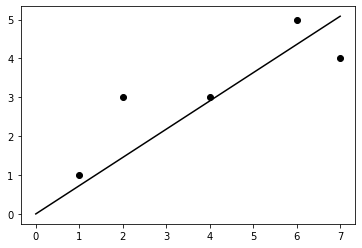

In [9]:
#回帰の実装

# 原点を通る直線で近似する
# 1次元のMSEの微分

def reg1dim1(x, y):
  a = np.dot(x, y) / (x**2).sum()
  return a

x = np.array([1, 2, 4, 6, 7]) # 入力
y = np.array([1, 3, 3, 5, 4]) # 出力
a = reg1dim1(x, y)

plt.scatter(x, y, color='k')
xmax = x.max()
plt.plot([0, xmax], [0, a*xmax], color="k")
plt.show()

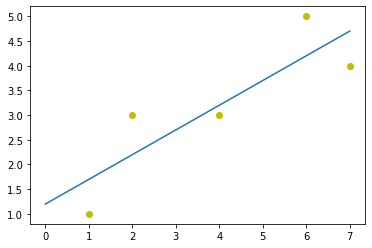

In [8]:
# 2次元のMSEの微分

def reg1dim2(x, y):
  n = len(x)
  a = ((np.dot(x, y) - y.sum() * x.sum() / n) /
       ((x**2).sum() -(x.sum()**2)/n))
  b = (y.sum() - a * x.sum()) / n
  return a, b

x = np.array([1, 2, 4, 6, 7])
y = np.array([1, 3, 3, 5, 4])
a, b = reg1dim2(x, y)

plt.scatter(x, y, color='y')
xmax = x.max()
plt.plot([0, xmax], [b, a * xmax + b])
plt.show()

In [0]:
import jax.numpy as np
from scipy import linalg

class LinearRegression():

  def __init__(self):
    self.w_ = None
  
  def fit(self, X, t):
    ones = np.ones(X.shape[0]).reshape(X.shape[0], 1)
    Xtil = np.concatenate((ones, X), 1)
    A = np.dot(Xtil.T, Xtil)
    b = np.dot(Xtil.T, t)
    self.w_ = linalg.solve(A, b)
  
  def predict(self, X):
    if X.ndim == 1:
      X = X.reshape(1, -1)
    ones = np.ones(X.shape[0]).reshape(X.shape[0],1)
    Xtil = np.concatenate((ones, X), 1)
    return np.dot(Xtil, self.w_)

In [104]:
from mpl_toolkits.mplot3d import axes3d
n = 100
scale = 10

key = random.PRNGKey(0)
X = random.uniform(key, (n, 2), minval=0, maxval=1)*scale
w0 = 1
w1 = 2
w2 = 3

y = w0 +w1*X[:, 0] + w2*X[:, 1] + random.normal(key, (n,))

model = LinearRegression()
model.fit(X, y)
print('coefficient:', model.w_)
print('predict value from (1, 1):', model.predict(np.array([1, 1])))

coefficient: [1.0527477 2.0223231 2.9845057]
predict value from (1, 1): [6.0595765]


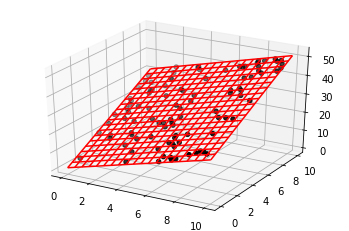

In [105]:
xmesh, ymesh = np.meshgrid(np.linspace(0, scale, 20),
                              np.linspace(0, scale, 20))
zmesh = (model.w_[0] 
          + model.w_[1] * xmesh.ravel() 
          + model.w_[2] * ymesh.ravel()).reshape(xmesh.shape)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], y, color = 'k')
ax.plot_wireframe(xmesh, ymesh, zmesh, color='r')
plt.show()

### 

In [0]:
import csv

In [0]:
PATH = '/content/drive/My Drive/Analytics/Colab Notebooks/learning_numpy.jax/'
Xy = []
with open(PATH+'winequality-red.csv') as fp:
  count = 0
  for row in csv.reader(fp, delimiter=";"):
    if count == 0:
      count += 1
      continue
    row = [float(s) for s in row]
    Xy.append(row)

In [134]:
Xy = np.array(Xy, dtype=np.float64)

/usr/local/lib/python3.6/dist-packages/jax/lax/lax.py:5385: UserWarning: Explicitly requested dtype <class 'jax.numpy.lax_numpy.float64'> requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  warnings.warn(msg.format(dtype, fun_name , truncated_dtype))


In [0]:
# 訓練/テスト用に分ける
